In [1]:
from super_gradients.training import models
best_model = models.get('yolo_nas_l',
                        num_classes=1,
                        checkpoint_path="checkpoints/my_first_yolonas_run_2/ckpt_best.pth")

[2023-06-15 11:23:29] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/yihwee/sg_logs/console.log


/home/yihwee/anaconda3/envs/torch/lib/python3.7/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-06-15 11:23:32] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-06-15 11:23:32] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-06-15 11:23:32] WARNING - export.py - Failed to import pytorch_quantization
[2023-06-15 11:23:32] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-06-15 11:23:33] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints/my_first_yolonas_run_2/ckpt_best.pth EMA checkpoint.


In [2]:
from PIL import Image
import torchvision.transforms as transforms
import torch
from craft_text_detector import Craft
import cv2
from operator import itemgetter

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
class Cropping:
    def __init__(self):
        """
        Initialization
        Args:  
            number_model_pathh (str): Path of the model for prediction on ic number.
     
            name_model_pathh (str): Path of the model for prediction on name.
                            
        """

        self.TARGET_HEIGHT = 32


    def get_ic_number_fixed_region(self, image):
        return image[115:200, 5:320]


    def get_name_fixed_region(self, image):
        return image[300:400, 0:550]


    def calculate_area(self, points):
        x_min = points[0][0]
        x_max = points[1][0]
        y_min = points[0][1]
        y_max = points[2][1]
        return (x_max - x_min) * (y_max - y_min)


    def crop_ic_number(self, image, craft):
        """Detect IC number region using CRAFT.

        Args:
            image: IC number region from a resized (520 x 840) IC image
            craft: An instance of CRAFT

        Returns:
            An image containing IC number or text. Height must be 32 pixels, width varies.
        """
        prediction_result = craft.detect_text(image)

        h_min = 30
        w_min = 250
        if len(prediction_result["boxes"]) == 0:
            x_min = 40
            x_max = x_min + w_min
            y_min = 24
            y_max = y_min + h_min

        else:
            areas = []
            for points in prediction_result["boxes"]:
                areas.append(self.calculate_area(points))
            index, _ = max(enumerate(areas), key=itemgetter(1))
            points = prediction_result["boxes"][index]
            y_min = points[0][1] 
            y_max = max(points[2][1], y_min + h_min)
            x_min = min(points[0][0], 40)
            x_max = max(points[1][0], x_min + w_min / self.TARGET_HEIGHT * (y_max - y_min))
            
            val = 15
            #Modified to have loose margin
            y_min = y_min - val if y_min >= val else 0
            y_max += val
            x_min = x_min - val if x_min >= val else 0
            x_max += val
        
        image = image[int(y_min) : int(y_max), int(x_min) : int(x_max)]
        
        return image


    def crop_name(self, image, craft):
        """Detect IC name region using CRAFT.

        Args:
            image: IC name region from a resized (520 x 840) IC image
            craft: an instance of CRAFT

        Returns:
            An image containing IC number or text. Height must be 32 pixels, width varies.
        """
        prediction_result = craft.detect_text(image)

        h_min = 24
        w_min = 140

        if len(prediction_result["boxes"]) == 0:
            x_min = 30
            x_max = x_min + w_min
            y_min = 38
            y_max = y_min + h_min
            
        else:
            areas = []
            for points in prediction_result["boxes"]:
                areas.append(self.calculate_area(points))
            index, _ = max(enumerate(areas), key=itemgetter(1))
            points = prediction_result["boxes"][index]
            y_min = points[0][1]
            y_max = max(points[2][1], y_min + h_min)
            x_min = min(points[0][0], 60)
            x_max = max(points[1][0], x_min + w_min / self.TARGET_HEIGHT * (y_max - y_min))

            #Modified to have loose margin
            val = 15
            #Modified to have loose margin
            y_min = y_min - val if y_min >= val else 0
            y_max += val
            x_min = x_min - val if x_min >= val else 0
            x_max += val
            
        image = image[int(y_min) : int(y_max), int(x_min) : int(x_max)]

        return image    
    

In [48]:
best_model = models.get('yolo_nas_l',
                    num_classes=1,
                    checkpoint_path="checkpoints/my_first_yolonas_run_2/ckpt_best.pth")
    
def od(im):

    
    predictions = best_model.predict(im, conf = 0.5)
    prediction_objects = list(predictions._images_prediction_lst)[0]
    bboxes = prediction_objects.prediction.bboxes_xyxy

    int_labels = prediction_objects.prediction.labels.astype(int)
    #class_names = prediction_objects.class_names
    #pred_classes = [class_names[i] for i in int_labels]
    
    if len(int_labels) == 0:
        return 'pass'
    else:
        return 'fail'

[2023-06-15 16:25:55] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints/my_first_yolonas_run_2/ckpt_best.pth EMA checkpoint.


In [49]:
# image: PIL image
def predict(image):
    craft = Craft(
        output_dir=None,
        export_extra=False,
        crop_type="box",
        cuda=True,
        text_threshold=0.8,
        low_text=0.5,
    )
    
    ld = Cropping()
    image = cv2.resize(image,(840, 530))
    
    ic_number_im = ld.get_ic_number_fixed_region(image)
    ic_number_im = ld.crop_ic_number(ic_number_im, craft)
    ic_number_im = Image.fromarray(ic_number_im)
    
    name_im = ld.get_name_fixed_region(image)        
    name_im = ld.crop_name(name_im, craft)
    name_im = Image.fromarray(name_im)
    
    return [od(ic_number_im), od(name_im)]

    

In [50]:
image = cv2.imread("/data/yihwee/External dataset/2023-CustomerData/minor/_OjCeizQjezWgmEnDgvB.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

results = predict(image)
results

/home/yihwee/anaconda3/envs/torch/lib/python3.7/site-packages/torchvision/models/_utils.py:253: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will be removed in 0.15. Please access them via the appropriate Weights Enum instead.
  "Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and will "
/home/yihwee/anaconda3/envs/torch/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/home/yihwee/anaconda3/envs/torch/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  w

['pass', 'pass']

In [41]:
import numpy as np
import pandas as pd
import os

path = r'/data/yihwee/External dataset/2023-CustomerData/minor'

array = []
for image_path in os.listdir(path):
    input_path = os.path.join(path, image_path)
    image = cv2.imread(input_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = predict(image)
    array.append([image_path, results[0], results[1]])

In [42]:
df = pd.DataFrame(array, columns = ['Name', 'yolo_nas2_num', 'yolo_nas2_name'])
df.to_csv('yolo_nas2_0.3.csv', index = False)

In [51]:
import numpy as np
import pandas as pd
import os

path = r'/data/yihwee/External dataset/2023-CustomerData/physical'

array1 = []
for image_path in os.listdir(path):
    input_path = os.path.join(path, image_path)
    image = cv2.imread(input_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = predict(image)
    array1.append([image_path, results[0], results[1]])

KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(array1, columns = ['Name', 'num', 'name'])
df['final'] = df.apply(lambda x:0 if x['num'] == 'pass' and x['name'] =='pass' else 1, axis=1)
df.to_excel('final_physical_2023_yolo_nas2_0.5.xlsx', index=False)

In [25]:
# image: PIL image
def predict2(image):
    craft = Craft(
        output_dir=None,
        export_extra=False,
        crop_type="box",
        cuda=True,
        text_threshold=0.8,
        low_text=0.5,
    )
    
    ld = Cropping()
    image = cv2.resize(image,(840, 530))
    
    ic_number_im = ld.get_ic_number_fixed_region(image)
    ic_number_im = ld.crop_ic_number(ic_number_im, craft)
    ic_number_im = Image.fromarray(ic_number_im)
    
    name_im = ld.get_name_fixed_region(image)        
    name_im = ld.crop_name(name_im, craft)
    name_im = Image.fromarray(name_im)
    
    return [ic_number_im, name_im]


In [26]:
from PIL import Image
from IPython.display import display

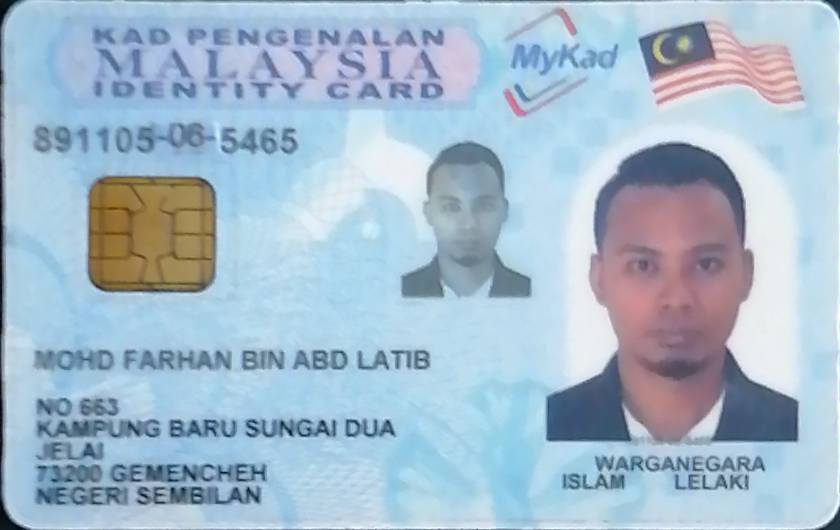

In [30]:
image = cv2.imread("/data/yihwee/External dataset/2023-CustomerData/minor/kQbc_0No9WxB01ulZh2i.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image,(840, 530))
display(Image.fromarray(image))

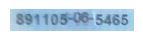

In [31]:
ic, name = predict2(image)
best_model.predict(ic, conf = 0.3).show()

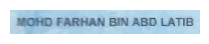

In [32]:
best_model.predict(name, conf = 0.3).show()